# Time-Series Research Project

- Researched by Shane Stoll
- Advised by Uzma Mushtaque

# Libraries to import

In [102]:
from datetime import datetime
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import yfinance as yf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
import pandas_ta as ta
from projectpro import model_snapshot, checkpoint
from keras.layers import LSTM, SimpleRNN
from keras.models import Sequential
from keras.layers import Dense

In [103]:
keras.backend.set_image_data_format("channels_last")
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
#yf.pdr_override()
%matplotlib inline

In [104]:
import pandas as pd

# Fetch NVIDIA data (Scaled using Min-Max Scaler with relevant columns (Open, High, Low, Close, Adjusted Close, and Volume) normalized to values between 0 and 1)
dataset = yf.download('NVDA', start='2010-01-01', end='2024-08-28')

# Display the first few rows
print(dataset.head())

# Save the data to a CSV file
dataset.to_csv('nvidia_stock_data.csv')


[*********************100%***********************]  1 of 1 completed

               Open    High      Low    Close  Adj Close     Volume
Date                                                               
2010-01-04  0.46275  0.4655  0.45275  0.46225   0.423952  800204000
2010-01-05  0.46050  0.4740  0.46050  0.46900   0.430143  728648000
2010-01-06  0.46875  0.4730  0.46425  0.47200   0.432894  649168000
2010-01-07  0.46950  0.4715  0.45925  0.46275   0.424410  547792000
2010-01-08  0.45900  0.4670  0.45625  0.46375   0.425328  478168000


In [105]:
def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("Nvidia stock price")
    plt.show()

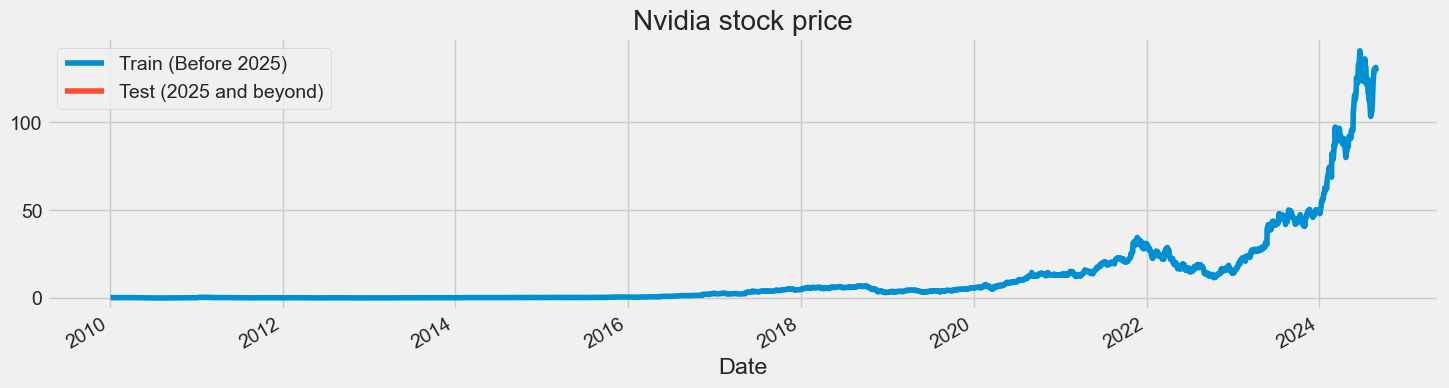

In [106]:
tstart = 2010
tend = 2024

train_test_plot(dataset, tstart, tend)

# Create train and test datasets

In [107]:
# Check the column names in your dataset to ensure 'Date' is present
print(dataset.columns)

# Reload the dataset, ensuring the 'Date' column is there
dataset = pd.read_csv('nvidia_stock_data.csv')

# Convert 'Date' to datetime if necessary
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Set 'Date' as the index
dataset.set_index('Date', inplace=True)

# Verify the columns after processing
print(dataset.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [108]:
# Adjust the train_test_split function to use proper date strings and index
def train_test_split(dataset, train_start, train_end, columns=['High']):
    train = dataset.loc[train_start:train_end, columns].values
    test = dataset.loc[train_end:, columns].values
    return train, test

# Set correct date ranges for training and testing
train_start = '2010-01-01'
train_end = '2021-12-31'

# Split the data
training_set, test_set = train_test_split(dataset, train_start, train_end)

# Check the sizes of the training and test sets
print(f"Training set size: {len(training_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 3021
Test set size: 667


# Scaling dataset values

In [109]:
# sc = MinMaxScaler(feature_range=(0, 1))
# training_set = training_set.reshape(-1, 1)
# training_set_scaled = sc.fit_transform(training_set)

# Initialize the MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))

# Scale the training data
training_set_scaled = sc.fit_transform(training_set)

# Scale the test data
test_set_scaled = sc.transform(test_set)

# Creating overlapping window batches

In [110]:
n_steps = 60
features = 1

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [111]:
# Reshape into X=t and Y=t+1
# Split the training and test data into sequences
X_train, y_train = split_sequence(training_set_scaled, n_steps)
X_test, y_test = split_sequence(test_set_scaled, n_steps)

# Reshape the input data to 3D (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Evaluation

In [112]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def plot_predictions(test, predicted, title):
    plt.figure(figsize=(10,6))
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title(f'{title}')
    plt.xlabel("Time")
    plt.ylabel(f'{title}')
    plt.legend()
    plt.show()
    
def plot_loss(history):
    plt.figure(figsize = (10,6))
    plt.plot(history.history['loss'], label='loss')
    plt.legend(loc='best')
    plt.show()

# Calculate Mean Squared Error (MSE)
def return_mse(y_test_scaled, predicted_stock_price):
    mse = mean_squared_error(y_test_scaled, predicted_stock_price)
    print(f"Mean Squared Error: {mse:.2f}")

# Calculate Mean Absolute Error (MAE)
def return_mae(y_test_scaled, predicted_stock_price):
    mae = mean_absolute_error(y_test_scaled, predicted_stock_price)
    print(f"Mean Absolute Error: {mae:.2f}")

# Calculate Root Mean Squared Error (RMSE)
def return_rmse(y_test_scaled, predicted_stock_price):
    rmse = np.sqrt(mean_squared_error(y_test_scaled, predicted_stock_price))
    print(f"Root Mean Squared Error: {rmse:.2f}")

# Calculate Mean Absolute Percentage Error (MAPE)
def return_mape(y_test_scaled, predicted_stock_price):
    mape = np.mean(np.abs((y_test_scaled - predicted_stock_price) / y_test_scaled)) * 100
    print(f"Mean Absolute Percentage Error: {mape:.2f}%")

# Recurrent Neural Network **(RNN)**

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0681 - val_loss: 3.6977
Epoch 2/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0510 - val_loss: 3.2142
Epoch 3/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0456 - val_loss: 2.7732
Epoch 4/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0367 - val_loss: 2.3590
Epoch 5/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0301 - val_loss: 2.0046
Epoch 6/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0256 - val_loss: 1.6302
Epoch 7/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0193 - val_loss: 1.2960
Epoch 8/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0148 - val_loss: 0.9579
Epoch 9/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0114 - val_loss: 0.6717
Epoch 10/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0079 - val_loss: 0.4418
Epoch 11/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0050 - val_loss: 0.2734
Epoch 12/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0

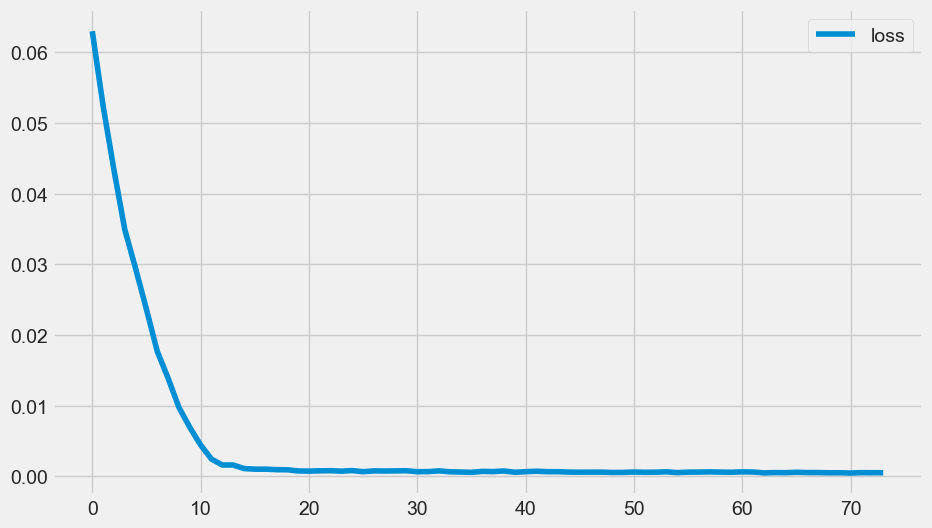

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


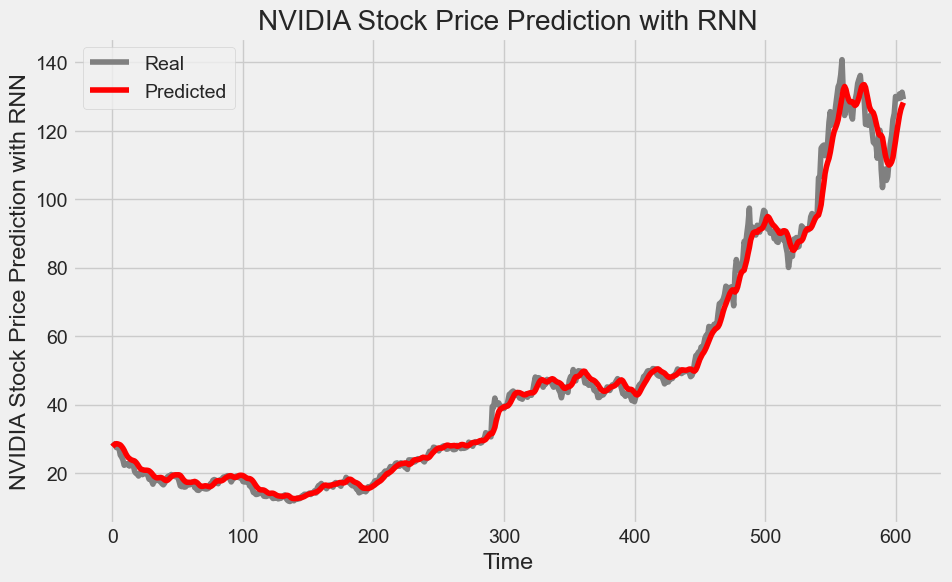

In [113]:
from keras.layers import SimpleRNN, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Adjust hyperparameters for fine-tuning
units = 150  # Number of RNN units
dropout_rate = 0.3  # Dropout rate to prevent overfitting
learning_rate = 0.000005  # Further reduce learning rate
epochs = 200  # Increase number of epochs

# Build the refined RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=units, activation='relu', input_shape=(n_steps, 1), return_sequences=True))
model_rnn.add(Dropout(dropout_rate))  # Add regularization
model_rnn.add(SimpleRNN(units=units, activation='relu'))
model_rnn.add(Dense(units=1))

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=learning_rate)
model_rnn.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model_rnn.fit(X_train, y_train, epochs=epochs, batch_size=64,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

plot_loss(history)

# Predict stock prices
predicted_stock_price = model_rnn.predict(X_test)

# Inverse transform the predicted stock prices to reverse scaling values to the original scale
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Inverse transform the y_test values (real stock prices)
y_test_scaled = sc.inverse_transform(y_test.reshape(-1, 1))

plot_predictions(y_test_scaled, predicted_stock_price, "NVIDIA Stock Price Prediction with RNN")

### Calculate the error for different evaluation metrics

In [115]:
'''
Lower MSE means that the squared deviations between the predicted and actual stock prices are smaller, 
indicating that the model is making closer predictions on average. 
However, MSE can be sensitive to outliers (since the errors are squared).
'''
return_mse(y_test_scaled, predicted_stock_price)

'''
Lower MAE means that the model's predictions are closer to the actual stock prices on average. 
Since this metric is measured in the same units as the stock price (dollars), it’s easy to interpret.
'''
return_mae(y_test_scaled, predicted_stock_price)

'''
A lower MAPE means that the predictions are closer to the actual values as a percentage of the stock price. 
This metric is useful for understanding the relative accuracy of predictions, especially when dealing with a range of stock prices.
'''
return_rmse(y_test_scaled, predicted_stock_price)

'''
Lower RMSE means that the average difference between the predicted and actual stock prices is smaller. 
RMSE is sensitive to large deviations due to the squaring of errors.
'''
return_mape(y_test_scaled, predicted_stock_price)

Mean Squared Error: 9.88
Mean Absolute Error: 2.00
Root Mean Squared Error: 3.14
Mean Absolute Percentage Error: 4.51%


# Long-short Term Model **(LSTM)**

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 0.0119 - val_loss: 0.2416
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 4.1205e-04 - val_loss: 0.0661
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 3.0131e-04 - val_loss: 0.0329
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 2.9420e-04 - val_loss: 0.0148
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 3.0170e-04 - val_loss: 0.0134
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - loss: 2.0465e-04 - val_loss: 0.0202
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - loss: 2.9994e-04 - val_loss: 0.0179
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 1.9577e-04 - val_loss: 0.0372
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - loss: 1.9897e-04 - val_loss: 0.0331
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - loss: 1.7032e-04 - val_loss: 0.0580
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 2.3178e-04 - val_loss: 0.0345
Epoch 12/200
93/93 ━━━

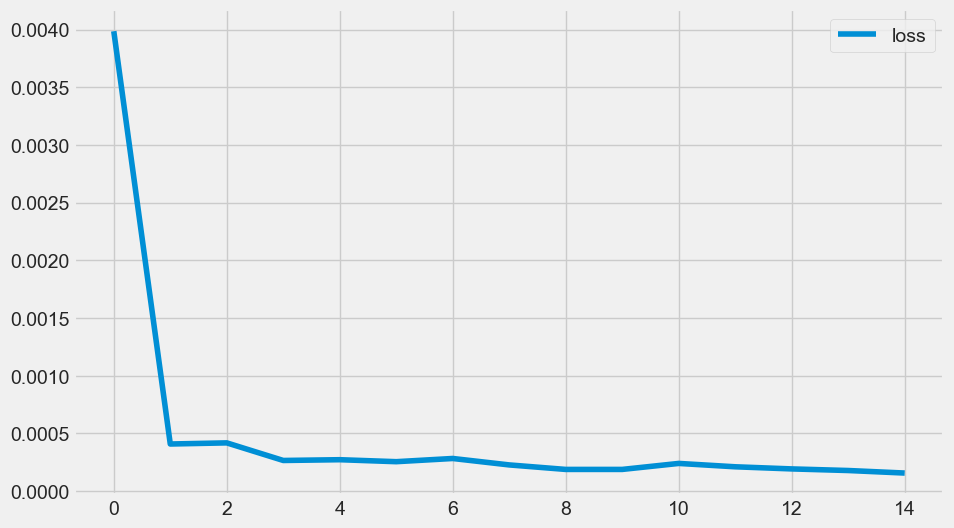

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


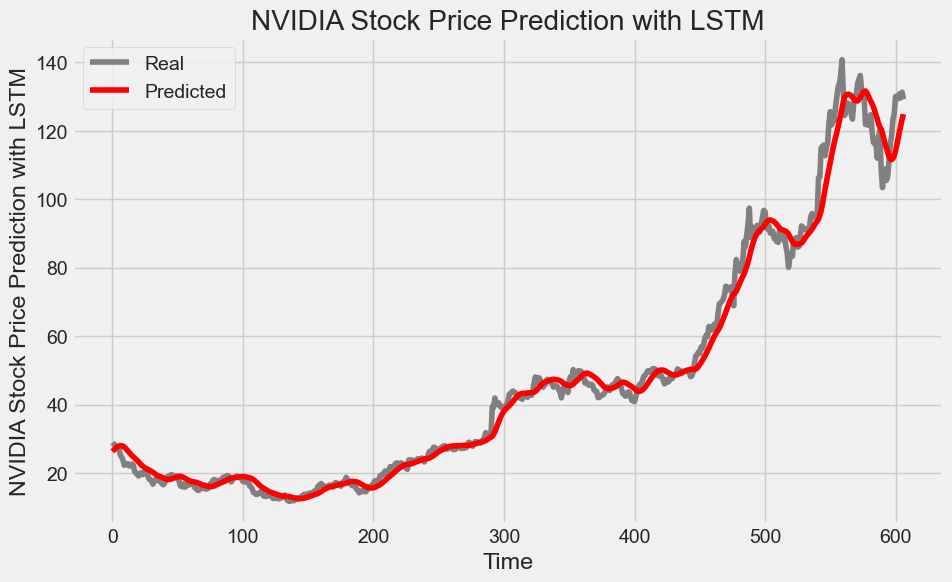

In [148]:
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Set the hyperparameters for the LSTM model
n_steps = 30
units = 300  # Number of LSTM units
dropout_rate = 0.3  # Dropout rate to prevent overfitting
learning_rate = 0.0003  # Lower learning rate for better learning
epochs = 200  # Set number of epochs

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=units, activation='relu', input_shape=(n_steps, 1), return_sequences=True))
model_lstm.add(Dropout(dropout_rate))
model_lstm.add(LSTM(units=units, activation='relu'))
model_lstm.add(Dense(units=1))

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=learning_rate)
model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the LSTM model
history = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

plot_loss(history)

# Predict stock prices using the LSTM model
predicted_stock_price_lstm = model_lstm.predict(X_test)

# Inverse transform the predicted stock prices
predicted_stock_price_lstm = sc.inverse_transform(predicted_stock_price_lstm)

plot_predictions(y_test_scaled, predicted_stock_price_lstm, "NVIDIA Stock Price Prediction with LSTM")

In [149]:
'''
Lower MSE means that the squared deviations between the predicted and actual stock prices are smaller, 
indicating that the model is making closer predictions on average. 
However, MSE can be sensitive to outliers (since the errors are squared).
'''
return_mse(y_test_scaled, predicted_stock_price_lstm)

'''
Lower MAE means that the model's predictions are closer to the actual stock prices on average. 
Since this metric is measured in the same units as the stock price (dollars), it’s easy to interpret.
'''
return_mae(y_test_scaled, predicted_stock_price_lstm)

'''
A lower MAPE means that the predictions are closer to the actual values as a percentage of the stock price. 
This metric is useful for understanding the relative accuracy of predictions, especially when dealing with a range of stock prices.
'''
return_rmse(y_test_scaled, predicted_stock_price_lstm)

'''
Lower RMSE means that the average difference between the predicted and actual stock prices is smaller. 
RMSE is sensitive to large deviations due to the squaring of errors.
'''
return_mape(y_test_scaled, predicted_stock_price_lstm)

Mean Squared Error: 15.90
Mean Absolute Error: 2.65
Root Mean Squared Error: 3.99
Mean Absolute Percentage Error: 6.10%
